In [23]:
import pandas as pd
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
df_orig = pd.read_csv('data_csv.csv')
df_orig = df_orig.drop(['num', 'year', 'day', 'time', 'month','1d_water_level','2d_water_level','3d_water_level','4d_water_level','5d_water_level','6d_water_level'], axis=1)

print(df_orig)
print('-----------------------------------------------------------------------------------------------\n\n')

df_1 = df_orig[2891:2892]
print(df_1)

      inflow  1_basin_rain  1a_rain  1b_rain  1c_rain  1d_rain  \
0      189.1           6.4      7.0      7.0      7.0      8.0   
1      217.0           6.3      7.0      8.0      7.0      8.0   
2      251.4           6.4      7.0      9.0      7.0      8.0   
3      302.8           7.3      7.0     10.0      7.0      8.0   
4      384.8           8.2      7.0     12.0      8.0     10.0   
...      ...           ...      ...      ...      ...      ...   
3046     NaN           2.4      1.0      0.0      0.0      0.0   
3047     NaN           2.4      1.0      0.0      0.0      0.0   
3048     NaN           2.4      1.0      0.0      0.0      0.0   
3049     NaN           2.4      1.0      0.0      0.0      0.0   
3050     NaN           2.4      1.0      0.0      0.0      0.0   

      1e_water_level  2_basin_rain  2a_rain  2b_rain  ...  5b_rain  5c_rain  \
0                2.5           6.3      7.0      7.0  ...      7.0      8.0   
1                2.5           6.4      7.0      

In [53]:
res = pd.DataFrame(columns=['idx', 'number'])
for i in range(1,2):
    print('------------------'+str(i))
    #df = pd.read_csv('merge%d.csv' %i)
    df = pd.read_csv('data_csv.csv')
    df = df.dropna()
    df = df.drop(['num', 'year', 'day', 'time', 'month','1d_water_level','2d_water_level','3d_water_level','4d_water_level','5d_water_level','6d_water_level'], axis=1)
    train_dataset = df.sample(frac=1.0,random_state=0)
    train_stats = train_dataset.describe()
    train_stats.pop('inflow')
    train_stats = train_stats.transpose()
    train_stats
    train_labels = train_dataset.pop('inflow')

    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    normed_train_data = norm(train_dataset)

    def build_model():
        model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(2, activation='relu'),
        layers.Dense(1)
        ])

        optimizer = tf.keras.optimizers.Adam(0.01)

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
        return model

    model = build_model()

    example_batch = normed_train_data[:10]
    example_result = model.predict(example_batch)
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')

    EPOCHS = 300

    history = model.fit(
        normed_train_data, train_labels,
        epochs=EPOCHS, validation_split = 0.2, verbose=0,
        callbacks=[PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(hist)
    df_1 = df_orig[2890+i:2891+i]
    df_1 = df_1.drop(['inflow'], axis=1)
    normed_df_1 = norm(df_1)
    
    predict_result = model.predict(normed_df_1)
    res = res.append(pd.DataFrame([[i, predict_result]], columns=['idx', 'number']), ignore_index=True)
    
    
print(res)

------------------1

....................................................................................................
....................................................................................................
....................................................................................................             loss          mae           mse      val_loss     val_mae  \
0    2.552639e+06  1001.568909  2.552639e+06  1.645790e+06  827.373413   
1    7.061569e+05   507.510498  7.061569e+05  5.194762e+05  360.887848   
2    5.087866e+05   391.456451  5.087866e+05  4.760109e+05  311.378540   
3    5.542613e+05   403.512726  5.542613e+05  9.213749e+05  504.257568   
4    3.970863e+05   347.615875  3.970863e+05  3.392404e+05  311.031158   
..            ...          ...           ...           ...         ...   
295  3.194491e+04   100.750633  3.194491e+04  5.116685e+04  133.319443   
296  2.071707e+04    81.178848  2.071707e+04  4.234229e+04  103.628159   
297  2.7007

             loss         mae           mse       val_loss     val_mae  \
0    1.910411e+06  801.565002  1.910411e+06  865479.500000  497.302399   
1    7.480046e+05  477.796875  7.480046e+05  635554.875000  389.055908   
2    6.520747e+05  444.939056  6.520747e+05  491823.093750  427.705231   
3    6.107376e+05  418.312622  6.107376e+05  382321.875000  387.607880   
4    5.396459e+05  405.783539  5.396459e+05  327042.062500  316.861084   
..            ...         ...           ...            ...         ...   
295  4.466836e+04  113.637207  4.466836e+04   54381.628906  130.459885   
296  6.225025e+04  118.592415  6.225025e+04   40339.765625  107.835129   
297  5.326343e+04  110.863304  5.326343e+04  103299.531250  186.576904   
298  5.305075e+04  110.958908  5.305075e+04   95782.656250  174.879379   
299  5.306776e+04  120.409126  5.306776e+04   41712.742188  104.479240   

           val_mse  epoch  
0    865479.500000      0  
1    635554.875000      1  
2    491823.093750      2  

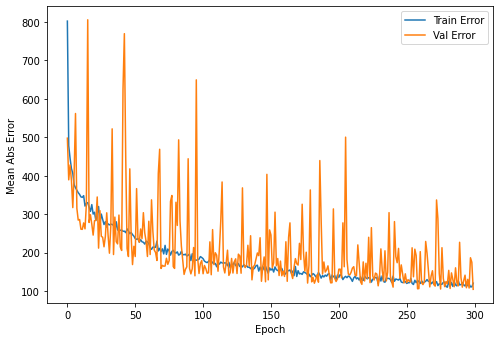

In [52]:
import matplotlib.pyplot as plt


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist.tail()

  print(hist)

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')

  plt.legend()

  plt.savefig('myfigure1.pdf')
  fig2 = plt.gcf()
  plt.show()


plot_history(history)

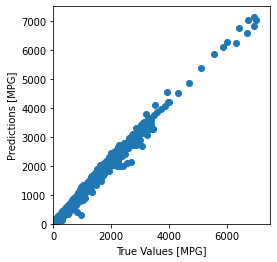

In [45]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

train_predictions = model.predict(normed_train_data).flatten()
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig('prediction.pdf')